In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sqlite3
import dateutil
import datetime as dt

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline


import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
link18 = '2009-01-01-2020-12-31.csv'
df = pd.read_csv(link18)

In [3]:
selected_countries = ['Malawi', 'Mozambique', 'Madagascar', 'Zimbabwe', 'Zambia',
                      'Democratic Republic of the Congo',        
        'Sudan', 'South Sudan', 'Ethiopia', 'Somalia', 'Kenya','Uganda',      
                'Mali','Niger','Cameroon', 'Nigeria','Chad']

In [4]:
df_clean = df[['data_id', 'iso',  'event_date',
       'year',  'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1',  'actor2', 'assoc_actor_2', 
       'interaction',  'country', 'admin1', 
       'location', 'latitude', 'longitude', 'notes', 'fatalities', 'iso3']]

In [5]:
df_africa = df_clean[df_clean.country.isin(selected_countries)]

In [6]:
df_africa.year.value_counts()

2020    14217
2019    11184
2018    10743
2017     9983
2016     9487
2014     8482
2015     8180
2013     7363
2012     5411
2011     2881
2010     2851
2009     2113
Name: year, dtype: int64

In [7]:
link = 'HFIC_new.geojson'
data_regions = gpd.read_file(link)
data_regions.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5930 entries, 0 to 5929
Data columns (total 7 columns):
index        5930 non-null int64
ADM1_CODE    5930 non-null int64
ADM0_NAME    5930 non-null object
Start        5930 non-null object
End          5930 non-null object
CS           5930 non-null float64
geometry     5930 non-null geometry
dtypes: float64(1), geometry(1), int64(2), object(3)
memory usage: 324.4+ KB


In [8]:
admin1 = 'Admin_1/afr_g2014_2013_1.shp'
all_admin1 = gpd.read_file(admin1)

In [9]:
regions = pd.merge(data_regions, all_admin1, how='left', on='ADM1_CODE')

In [10]:
regions.head()

,index,ADM1_CODE,ADM0_NAME_x,Start,End,CS,geometry_x,ADM1_NAME,ADM0_CODE,ADM0_NAME_y,CONTINENT,REGION,geometry_y
0,22108,69550,Zimbabwe,2020-06-30,2020-10-31,3.0,"POLYGON ((32.46210 -16.69821, 32.46248 -16.698...",Mashonaland East,271,Zimbabwe,Africa,Eastern Africa,"POLYGON ((32.46210 -16.69821, 32.46248 -16.698..."
1,6932,69550,Zimbabwe,2020-01-31,2020-02-29,3.0,"POLYGON ((32.46210 -16.69821, 32.46248 -16.698...",Mashonaland East,271,Zimbabwe,Africa,Eastern Africa,"POLYGON ((32.46210 -16.69821, 32.46248 -16.698..."
2,8327,69550,Zimbabwe,2019-06-30,2019-10-31,3.0,"POLYGON ((32.46210 -16.69821, 32.46248 -16.698...",Mashonaland East,271,Zimbabwe,Africa,Eastern Africa,"POLYGON ((32.46210 -16.69821, 32.46248 -16.698..."
3,18086,69550,Zimbabwe,2019-01-31,2019-02-28,3.0,"POLYGON ((32.46210 -16.69821, 32.46248 -16.698...",Mashonaland East,271,Zimbabwe,Africa,Eastern Africa,"POLYGON ((32.46210 -16.69821, 32.46248 -16.698..."
4,23882,69550,Zimbabwe,2018-10-31,2018-12-31,3.0,"POLYGON ((32.46210 -16.69821, 32.46248 -16.698...",Mashonaland East,271,Zimbabwe,Africa,Eastern Africa,"POLYGON ((32.46210 -16.69821, 32.46248 -16.698..."


In [11]:
for i in range(len(regions)):
    if regions.End[i] == '2020-02-29':
        regions.Start[i] = '2019-11-01'
    elif regions.End[i] == '2019-02-28':
        regions.Start[i] = '2019-01-01'

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
df_africa_ = df_africa[df_africa.admin1.isin(regions.ADM1_NAME.unique())].reset_index(drop=True)

In [12]:
regions_dura = regions[['ADM1_CODE','ADM1_NAME','Start', 'End', 'CS']].drop_duplicates().reset_index(drop=True)


In [13]:
two_month = dt.timedelta(days=60)
one_month = dt.timedelta(days=15)
regions_dura['Start_2'] = pd.to_datetime(regions_dura['Start']) - two_month
regions_dura['End_2'] = pd.to_datetime(regions_dura['End']) - one_month


In [14]:
df_africa_['event_date'] = pd.to_datetime(df_africa_['event_date'])

In [15]:
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
regions_dura.to_sql('regions', conn, index=False)
df_africa_.to_sql('df_africa_', conn, index=False)

In [16]:
qry = '''select * from df_africa_'''
df = pd.read_sql_query(qry, conn)
df.columns

Index(['data_id', 'iso', 'event_date', 'year', 'event_type', 'sub_event_type',
       'actor1', 'assoc_actor_1', 'actor2', 'assoc_actor_2', 'interaction',
       'country', 'admin1', 'location', 'latitude', 'longitude', 'notes',
       'fatalities', 'iso3'],
      dtype='object')

In [17]:
qry = '''    select  
       da.data_id,
       da.event_date, da.year,
       da.admin1, da.event_type, da.sub_event_type,
       da.actor1, da.assoc_actor_1,
       da.actor2, da.assoc_actor_2,
       da.interaction,da.country, da.admin1,
       da.location, da.latitude, da.longitude,
       da.notes, da.fatalities, 
       rs.ADM1_CODE, rs.Start, rs.End, rs.CS
    from
        df_africa_ as da
        join regions as rs on rs.ADM1_NAME = da.admin1
        where da.event_date <= rs.End_2
        and da.event_date >= rs.Start_2
    '''
df_joined = pd.read_sql_query(qry, conn)

In [18]:
df_joined.head()

,data_id,event_date,year,admin1,event_type,sub_event_type,actor1,assoc_actor_1,actor2,assoc_actor_2,...,admin1,location,latitude,longitude,notes,fatalities,ADM1_CODE,Start,End,CS
0,7737358,2020-10-16 00:00:00,2020,Edo,Riots,Violent demonstration,Rioters (Nigeria),#EndSARS,Unidentified Armed Group (Nigeria),None,...,Edo,Benin City,6.3351,5.6275,"On 16 October 2020, thousands of supporters of...",1,2219,2020-06-30,2020-10-31,2.0
1,7252503,2020-10-16 00:00:00,2020,Lagos,Riots,Violent demonstration,Rioters (Nigeria),#EndSARS,Unidentified Armed Group (Nigeria),None,...,Lagos,Alausa,6.6096,3.3566,"On 16 October 2020, supporters of the #EndSARS...",0,2230,2020-06-30,2020-10-31,2.0
2,7258392,2020-10-16 00:00:00,2020,Tombouctou,Protests,Peaceful protest,Protesters (Mali),Arab Ethnic Group (Mali); Tuareg Ethnic Group ...,None,None,...,Tombouctou,Timbuktu,16.7705,-3.0056,"On 16 October 2020, about nine hundred of memb...",0,1934,2020-06-30,2020-10-31,2.0
3,7252508,2020-10-16 00:00:00,2020,Lagos,Protests,Peaceful protest,Protesters (Nigeria),#EndSARS,None,None,...,Lagos,Lekki,6.4095,4.0915,"On 16 October 2020, supporters of the #EndSARS...",0,2230,2020-06-30,2020-10-31,2.0
4,7258413,2020-10-16 00:00:00,2020,Cabo Delgado,Battles,Armed clash,Military Forces of Mozambique (1990-),None,Islamist Militia (Mozambique),None,...,Cabo Delgado,Churumba,-12.5918,40.4218,Around 16 October 2020 (between 16 and 17 Octo...,0,2112,2020-06-30,2020-10-31,3.0


In [42]:
df_joined.to_csv('Social_conflict.csv')

## Cleaning

In [12]:
df_raw = pd.read_csv('Social_conflict.csv')

In [13]:
df = df_raw[['data_id', 'event_date', 'year', 'admin1', 'ADM1_CODE', 'event_type',
        'actor1', 'actor2', 
       'interaction', 'country',  'location', 'latitude',
       'longitude', 'notes', 'fatalities', 'Start', 'End', 'CS']]

In [14]:
df.loc[df['actor1'].str.contains('Protesters'), 'actor1'] = 'Protesters'
df.loc[df['actor1'].str.contains('Military'), 'actor1'] = 'Military'
df.loc[df['actor1'].str.contains('Rioters'), 'actor1'] = 'Rioters'
df.loc[df['actor1'].str.contains('Police Forces'), 'actor1'] = 'Police Forces'
df.loc[df['actor1'].str.contains('Unidentified Armed Group'), 'actor1'] = 'Unidentified Armed Group'
df.loc[df['actor1'].str.contains('AMISOM'), 'actor1'] = 'AMISOM'
df.loc[df['actor1'].str.contains('Militia'), 'actor1'] = 'Militia'
df.loc[df['actor1'].str.contains('Islamic State'), 'actor1'] = 'Islamic State'
df.loc[df['actor1'].str.contains('Government of'), 'actor1'] = 'Government'
df.loc[df['actor1'].str.contains('Pirate'), 'actor1'] = 'Pirates'
df.loc[df['actor1'].str.contains('Patriotic Front'), 'actor1'] = 'Patriotic Front'
df.loc[df['actor1'].str.contains('Private Security Forces'), 'actor1'] = 'Private Security Forces'
df.loc[df['actor1'].str.contains('Liberation Front'), 'actor1'] = 'Liberation Front'
df.loc[df['actor1'].str.contains('Liberation Movement-In Opposition'), 'actor1'] = 'Liberation Movement-In Opposition'

/Users/lavendershenghaozhang/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [15]:
df['actor2'] = df['actor2'].fillna('none')
df.loc[df['actor2'].str.contains('Civilians'), 'actor2'] = 'Civilians'
df.loc[df['actor2'].str.contains('Military'), 'actor2'] = 'Military'
df.loc[df['actor2'].str.contains('Islamic State'), 'actor2'] = 'Islamic State'
df.loc[df['actor2'].str.contains('Police Forces'), 'actor2'] = 'Police Forces'
df.loc[df['actor2'].str.contains('Militia'), 'actor2'] = 'Militia'
df.loc[df['actor2'].str.contains('AMISOM'), 'actor2'] = 'AMISOM'
df.loc[df['actor2'].str.contains('Rioters'), 'actor2'] = 'Rioters'
df.loc[df['actor2'].str.contains('Unidentified Armed Group'), 'actor2'] = 'Unidentified Armed Group'
df.loc[df['actor2'].str.contains('MINUSMA'), 'actor2'] = 'MINUSMA'
df.loc[df['actor2'].str.contains('Protesters'), 'actor2'] = 'Protesters'
df.loc[df['actor2'].str.contains('Patriotic Front'), 'actor2'] = 'Patriotic Front'
df.loc[df['actor2'].str.contains('Private Security Forces'), 'actor2'] = 'Private Security Forces'


/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
df.actor1.value_counts()[:10].sum()/df.actor1.value_counts().sum(), df.actor2.value_counts()[:10].sum()/df.actor2.value_counts().sum()


(0.9167034755317912, 0.9413925374869232)

In [17]:
actor_1 = []
actor_1.extend([i for i in df.actor1.value_counts()[:10].index])
df['actor_1'] = np.where(df.actor1.isin(actor_1),
                df.actor1, 'Other')

actor_2 = []
actor_2.extend([i for i in df.actor2.value_counts()[:10].index])
df['actor_2'] = np.where(df.actor2.isin(actor_2),
                df.actor2, 'Other')

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [18]:
count_raw = pd.DataFrame(df.groupby(['admin1', 'Start',
        'End', 'CS'])['data_id'].nunique()).reset_index()
count_raw

,admin1,Start,End,CS,data_id
0,Abia,2010-01-31,2010-04-30,2.0,8
1,Abia,2010-07-31,2010-10-31,2.0,2
2,Abia,2011-01-31,2011-04-30,1.0,2
3,Abia,2012-07-31,2012-10-31,1.0,1
4,Abia,2013-01-31,2013-04-30,1.0,1
...,...,...,...,...,...
2746,Zinder,2019-06-30,2019-10-31,2.0,1
2747,Zinder,2019-11-01,2020-02-29,2.0,2
2748,Zinder,2020-06-30,2020-10-31,2.0,1
2749,Zombo,2019-06-30,2019-10-31,2.0,1


In [19]:
counts = pd.DataFrame(df.groupby(['admin1','ADM1_CODE', 'Start',
        'End', 'CS', 'event_type']).agg({'data_id': 'nunique', 'fatalities': 'sum'}))

In [20]:
counts_pivot = counts.pivot_table('data_id', ['admin1', 'ADM1_CODE', 'Start', 'End', 'CS'], 'event_type').reset_index()

In [21]:
counts_pivot = counts_pivot.fillna(0).sort_values(by='Battles',ascending=False).reset_index()

In [22]:
counts_pivot.CS.value_counts()

1.0    1262
2.0     751
3.0     579
4.0     161
5.0       6
Name: CS, dtype: int64

# First Model

## Random Forest

## XGBoost

In [57]:
counts_pivot.columns

Index(['index', 'admin1', 'ADM1_CODE', 'Start', 'End', 'CS', 'Battles',
       'Explosions/Remote violence', 'Protests', 'Riots',
       'Strategic developments', 'Violence against civilians'],
      dtype='object', name='event_type')

In [58]:
X = counts_pivot[['Battles','Explosions/Remote violence', 'Protests', 'Riots',
       'Strategic developments', 'Violence against civilians']]
y = counts_pivot['CS']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [60]:
model = XGBClassifier(seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)

In [61]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 50.483%  Accuracy_train: 58.415% 


# Second Model - Adding Geophysical

In [23]:
phys = pd.read_csv('combo_all.csv')

In [24]:
phys.head()

,Unnamed: 0,ADM0_NAME_x,ADM1_CODE,Start,End,Evap_tavg_,Evap_tavg_std_,Lwnet_tavg,Lwnet_tavg_std,Qair_f_tavg,...,Wind_f_tavg_std,ozone_mean,ozone_std,npp_mean,npp_std,nl_mean,nl_std,nl_dataset,CS_y,geometry_x
0,0,Uganda,772,2009-10-01,2010-01-31,0.000017,0.000003,-88.988055,2.166723,0.010839,...,0.496833,261.000000,0.000000,641.791315,499.061177,0.048754,0.005281,DMSP,3.0,"POLYGON ((34.55464000000013 3.106570000000175,..."
1,1,Uganda,1261,2009-10-01,2010-01-31,0.000029,0.000002,-64.721100,1.589415,0.012707,...,0.208014,262.000000,0.000000,2065.279452,2835.782508,0.047925,0.006648,DMSP,2.0,"POLYGON ((34.22144902700018 1.643061499999988,..."
2,2,Somalia,2700,2009-10-01,2010-01-31,0.000010,0.000004,-81.675635,3.208694,0.014806,...,0.351184,258.631483,0.482400,58.710866,130.748302,0.048068,0.003006,DMSP,4.0,"POLYGON ((49.5010566710001 7.571147919000047, ..."
3,3,Uganda,3117,2009-10-01,2010-01-31,0.000045,0.000003,-54.026152,1.303146,0.013100,...,0.231864,263.000462,0.020028,-9271.084617,3181.977951,0.047467,0.002150,DMSP,1.0,POLYGON ((32.72652202900015 -0.149085647999947...
4,4,Uganda,47087,2009-10-01,2010-01-31,0.000039,0.000002,-51.766110,0.587657,0.012815,...,0.057524,263.631697,0.929722,2644.906507,3319.672321,0.051528,0.012715,DMSP,1.0,"POLYGON ((32.149610368 0.690105643000017, 32.1..."


In [25]:
## Merge
geo_social = pd.merge(counts_pivot, phys, on=['ADM1_CODE', 'End'], how='left')

In [26]:
X = geo_social[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean', 'Battles','Explosions/Remote violence', 'Protests', 'Riots',
       'Strategic developments', 'Violence against civilians']]
y = geo_social['CS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

## RFC

In [148]:
pipeline_rf_gr = Pipeline([('classifier', RandomForestClassifier(random_state = 10))])

rf_params = {'classifier__n_estimators':[20, 50, 100, 200],
        'classifier__criterion':['gini', 'entropy'],
             'classifier__max_depth':[3, 5, 8, 10, 12],
             'classifier__min_samples_split':[2, 5, 8,10],
             'classifier__min_samples_leaf':[2, 5, 8]}
grid_rf = GridSearchCV(pipeline_rf_gr, rf_params, cv=5)

grid_rf.fit(X_train, y_train)

# Mirror Mirror from GridSearch! Tell me what's the best parameters
print(grid_rf.best_params_)

/Users/lavendershenghaozhang/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'classifier__criterion': 'entropy', 'classifier__max_depth': 12, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 200}


In [111]:
clf=RandomForestClassifier(n_estimators=200, criterion = 'entropy', max_depth=12,
                        min_samples_leaf = 2, min_samples_split = 8,
                          random_state=10)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred=clf.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 59.300%  Accuracy_train: 93.941% 


In [112]:
test_rp = classification_report(y_test, y_pred)
print(test_rp)

              precision    recall  f1-score   support

         1.0       0.67      0.88      0.76       382
         2.0       0.43      0.31      0.36       213
         3.0       0.48      0.43      0.45       174
         4.0       0.74      0.24      0.36        59

    accuracy                           0.59       828
   macro avg       0.58      0.46      0.48       828
weighted avg       0.57      0.59      0.56       828



## XGBoost

In [113]:
model = XGBClassifier(seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)

In [114]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 56.763%  Accuracy_train: 72.605% 


In [115]:
## Tuning XGBoost
model = XGBClassifier(n_estimators = 50, objective='multi:softprob', subsample = 0.5,
            max_depth = 6, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)

In [116]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 59.420%  Accuracy_train: 88.659% 


# Third Model - combining categories

## 3 Categories

In [27]:
geo_social['CS_4'] = geo_social['CS'].replace(5, 4)
geo_social['CS_3'] = geo_social['CS_4'].replace(4, 3)
geo_social['CS_3'].value_counts()

1.0    1262
2.0     751
3.0     746
Name: CS_3, dtype: int64

In [118]:
X = geo_social[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean', 'Battles','Explosions/Remote violence', 'Protests', 'Riots',
       'Strategic developments', 'Violence against civilians']]
y = geo_social['CS_3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [119]:
## Tuning XGBoost
model = XGBClassifier(n_estimators = 50, objective='multi:softprob', subsample = 0.5,
            max_depth = 6, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)

In [120]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 65.217%  Accuracy_train: 89.746% 


## 2 Categories

In [28]:
geo_social['CS_2'] = geo_social['CS_3'].replace(1, 2)
geo_social['CS_2'].value_counts()

2.0    2013
3.0     746
Name: CS_2, dtype: int64

In [29]:
X = geo_social[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean', 'Battles','Explosions/Remote violence', 'Protests', 'Riots',
       'Strategic developments', 'Violence against civilians']]
y = geo_social['CS_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

## RFC

In [185]:
pipeline_rf_gr = Pipeline([('classifier', RandomForestClassifier(random_state = 10))])

rf_params = {'classifier__n_estimators':[20, 50, 100, 200],
        'classifier__criterion':['gini', 'entropy'],
             'classifier__max_depth':[3, 5, 8, 10, 12],
             'classifier__min_samples_split':[2, 5, 8,10],
             'classifier__min_samples_leaf':[2, 5, 8]}
grid_rf = GridSearchCV(pipeline_rf_gr, rf_params, cv=5)

grid_rf.fit(X_train, y_train)

# Mirror Mirror from GridSearch! Tell me what's the best parameters
print(grid_rf.best_params_)

{'classifier__criterion': 'gini', 'classifier__max_depth': 12, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [123]:
clf=RandomForestClassifier(n_estimators=100, criterion = 'gini', max_depth=10,
                        min_samples_leaf = 2, min_samples_split = 2,
                          random_state=10)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred=clf.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 81.643%  Accuracy_train: 92.595% 


## XGBoost

In [154]:
## Tuning XGBoost
model = XGBClassifier(n_estimators = 30, objective='binary:logistic', subsample = 0.55,
            max_depth = 5, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)

In [155]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
'Overfitting: %.3f%% ' % ((accuracy_score(y_test, y_pred)*100)-(accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 80.435%  Accuracy_train: 87.934%  Overfitting: -7.499% 


In [67]:
## Adding fatalities
counts_f = pd.DataFrame(df.groupby(['admin1','ADM1_CODE', 'Start',
        'End', 'CS'])['fatalities'].sum()).reset_index()

In [68]:
geo_social_f = pd.merge(geo_social, counts_f, on=['ADM1_CODE',  'End'], how='left')

In [69]:
X = geo_social_f[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean', 'Battles','Explosions/Remote violence', 'Protests', 'Riots',
       'Strategic developments', 'Violence against civilians', 'fatalities']]
y = geo_social_f['CS_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [84]:
## Tuning XGBoost
model = XGBClassifier(n_estimators = 70, objective='binary:logistic', subsample = 0.5,
            max_depth = 3, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)

In [85]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 80.435%  Accuracy_train: 85.966% 


# Fourth Model - adding notes from social conflicts

In [83]:
df['notes'] = df['notes'].fillna('In {}, none'.format(df['year']))

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
# The notes start with date
# This is not very relevant to NLP
# Get rid of that 
df['note_new'] = 'notes'
for i in range(len(df)):
    try:
        df['note_new'][i] = df['notes'][i].split('{}'.format(df.year[i]))[1]
    except IndexError:
        continue

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pan

In [85]:
# Combining, Actor 1, Actor 2, and notes together
df['event_des'] = df['actor_1'] + ", " + df['actor_2'] + df['note_new']

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
## Group to get all the text in one column
text_agg = pd.DataFrame(df.groupby(['ADM1_CODE', 'Start', 'End'])['event_des'].apply(lambda x: '; '.join(x))).reset_index()

In [87]:
text_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 4 columns):
ADM1_CODE    2759 non-null int64
Start        2759 non-null object
End          2759 non-null object
event_des    2759 non-null object
dtypes: int64(1), object(3)
memory usage: 86.3+ KB


In [88]:
## Joinin the phys data
geo_social_ = pd.merge(counts_pivot, phys, on=['ADM1_CODE', 'Start', 'End'], how='left')

In [89]:
stopwords = nltk.corpus.stopwords.words('english')
lemma = WordNetLemmatizer()

In [90]:
def note_text_lemma(reviewText):
    reviews = "".join([w for w in reviewText if w not in string.punctuation])
    tokens = re.split('\W+', reviews)
    review_clean = [lemma.lemmatize(ws) for ws in tokens if ws not in stopwords]
    return review_clean

In [91]:
text_agg['event_des_lem'] = text_agg['event_des'].apply(lambda x: note_text_lemma(str(x).lower()))

In [92]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer()
X_part_des = tfidf.fit_transform(text_agg['event_des']).toarray()
event_des_df = pd.DataFrame(X_part_des)

In [93]:
geo_social_text = pd.merge(geo_social_, text_agg, on=['ADM1_CODE', 'Start', 'End'], how='left')

In [95]:
geo_social_text1 = geo_social_text[['CS', 'Evap_tavg_',  'Lwnet_tavg',
        'Qair_f_tavg', 'Qh_tavg',
       'Qh_tavg_std',   'Qs_tavg', 
       'Rainf_f_tavg',  'SoilMoi00_10cm_tavg',
      'Swnet_tavg', 
       'Tair_f_tavg',  'Wind_f_tavg', 
       'ozone_mean',  'npp_mean',  'nl_mean', 'Battles',
       'Explosions/Remote violence', 'Protests', 'Riots',
       'Strategic developments', 'Violence against civilians']]

In [96]:
geo_social_mod = geo_social_text1.join(event_des_df)

In [97]:
geo_social_mod.head()

,CS,Evap_tavg_,Lwnet_tavg,Qair_f_tavg,Qh_tavg,Qh_tavg_std,Qs_tavg,Rainf_f_tavg,SoilMoi00_10cm_tavg,Swnet_tavg,...,12789,12790,12791,12792,12793,12794,12795,12796,12797,12798
0,2.0,1.0,-56.424135,0.017095,88.652784,24.864057,4.146653e-06,0.000021,0.276339,174.734430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,1.0,-58.126933,0.015241,13.913670,11.916337,3.834063e-06,0.000065,0.031368,170.479231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,-52.931726,0.017710,84.518220,19.534504,1.144371e-06,0.000015,0.268002,160.194757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,-66.171690,0.014467,133.372937,10.894519,8.672760e-07,0.000010,0.113308,212.950087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,1.0,-56.519306,0.017776,100.221937,16.497474,7.315361e-06,0.000022,0.256218,176.649513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
geo_social_mod['CS_2'] = geo_social_mod['CS'].replace(5, 3)
geo_social_mod['CS_2'] = geo_social_mod['CS'].replace(4, 3)
geo_social_mod['CS_2'] = geo_social_mod['CS'].replace(1, 2)

In [99]:
X_mod = geo_social_mod.drop(['CS', 'CS_2'], axis=1)
y = geo_social_mod['CS_2']
X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.3, random_state=12345)

In [100]:
## Tuning XGBoost
model = XGBClassifier(n_estimators = 50, objective='binary:logistic', subsample = 0.55,
            max_depth = 5, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)

In [101]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 75.725%  Accuracy_train: 90.678% 


# With Social Data - winner tunning

In [343]:
X = geo_social[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean', 'Battles','Explosions/Remote violence', 'Protests', 'Riots',
       'Strategic developments', 'Violence against civilians']]
y = geo_social['CS_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [41]:
# RFC tunning
pipeline_rf_gr = Pipeline([('classifier', RandomForestClassifier(random_state = 10))])

rf_params = {'classifier__n_estimators':[20, 50, 100, 200],
        'classifier__criterion':['gini', 'entropy'],
             'classifier__max_depth':[5, 6, 7, 8, 10],
             'classifier__min_samples_split':[2, 3,4, 5],
             'classifier__min_samples_leaf':[2,3, 4, 5]}
grid_rf = GridSearchCV(pipeline_rf_gr, rf_params, cv=5)

grid_rf.fit(X_train, y_train)

# Mirror Mirror from GridSearch! Tell me what's the best parameters
print(grid_rf.best_params_)

{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


In [166]:
clf=RandomForestClassifier(n_estimators=100, criterion = 'gini', max_depth=12,
                        min_samples_leaf = 2, min_samples_split = 5,
                          random_state=10)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred=clf.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 81.280%  Accuracy_train: 95.339% 


In [176]:
# tunning RFC
clf=RandomForestClassifier(n_estimators=105, criterion = 'gini', max_depth= 7,
                        min_samples_leaf = 4, min_samples_split = 2,
                          random_state=10)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred=clf.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
     'Overfitting: %.3f%%'% ((accuracy_score(y_test, y_pred)*100) - (accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 80.556%  Accuracy_train: 85.655%  Overfitting: -5.100%


In [344]:
# XGBoost Tunning
model = XGBClassifier(n_estimators = 60, objective='binary:logistic', subsample = 0.5,
                      tree_method = 'exact', grow_policy = 'lossguide',
                      sampling_method = 'gradient_based', min_child_weight = 0.1,
            max_depth = 3, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
     'Overfitting: %.3f%%'% ((accuracy_score(y_test, y_pred)*100) - (accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 80.797%  Accuracy_train: 84.982%  Overfitting: -4.185%


## Feature Importance

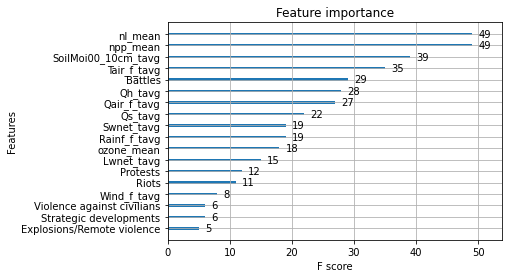

In [345]:
xgboost.plot_importance(model, max_num_features=18)

## Permutation Importance

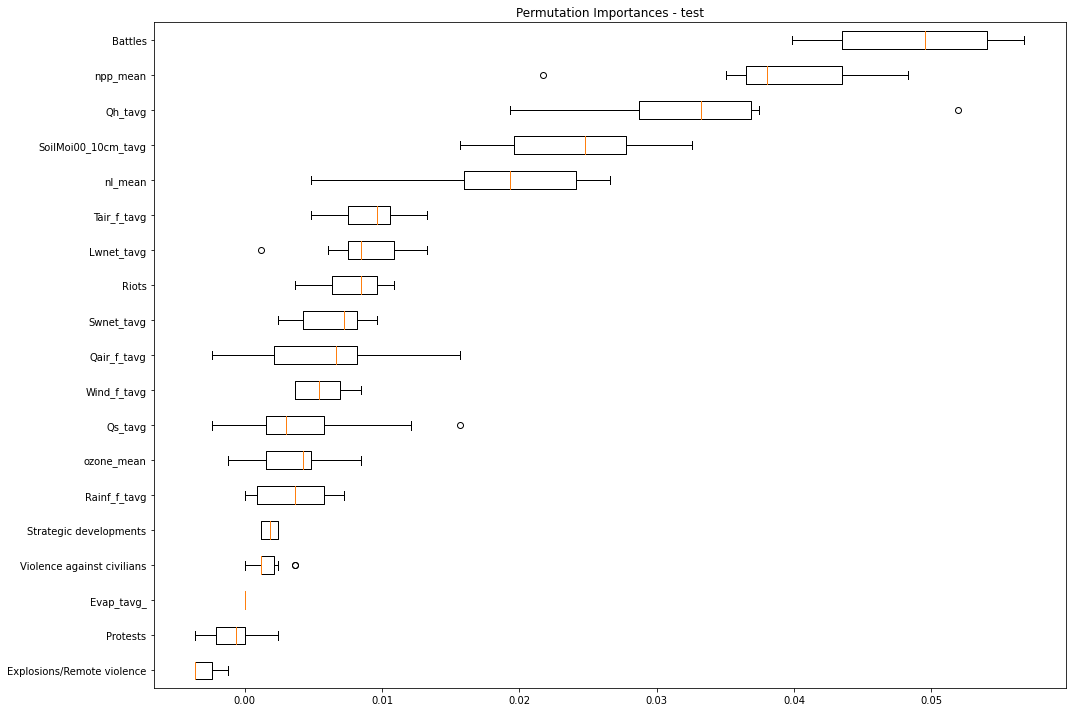

In [352]:
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances - test")
fig.tight_layout()

### Removing Negative Variables
Removing Protests and Explosions/Remote violence

In [105]:
X = geo_social[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean', 'Battles', 'Riots',
       'Strategic developments', 'Violence against civilians']]
y = geo_social['CS_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [108]:
# XGBoost Tunning
model = XGBClassifier(n_estimators = 70, objective='binary:logistic', subsample = 0.5,
                      tree_method = 'exact', grow_policy = 'lossguide',
                      sampling_method = 'gradient_based', min_child_weight = 0.1,
            max_depth = 3, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
     'Overfitting: %.3f%%'% ((accuracy_score(y_test, y_pred)*100) - (accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 81.039%  Accuracy_train: 85.500%  Overfitting: -4.461%


# Adding Indirect Events
Half of the data were not included as there were no events happened directly in the region. How about we add those events close to the region during the time period? Label them as 'indirect'.

In [61]:
geo_social['event_source'] = 'Direct'

In [102]:
## All CS
all_cards = data_regions[['ADM1_CODE', 'Start', 'End', 'CS', 'geometry']]
all_cards['unique'] = all_cards['ADM1_CODE'].astype(str) + "-" + all_cards['End']
direct_cards = geo_social[['ADM1_CODE', 'Start_x', 'End']]
direct_cards['unique'] = direct_cards['ADM1_CODE'].astype(str) + "-" + direct_cards['End']
direct_unique = direct_cards['unique'].to_list()

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [103]:
indirect_cards = all_cards[~all_cards.unique.isin(direct_unique)].reset_index(drop=True)

In [104]:
indirect_cards['event_source'] = 'Indirect'

In [126]:
indirect_cards_geo_r = gpd.GeoDataFrame(indirect_cards, geometry='geometry')
indirect_cards_geo = pd.merge(indirect_cards_geo_r, regions[['ADM1_CODE', 'ADM0_NAME_x']],
                        on = 'ADM1_CODE', how = 'left')

In [130]:
indirect_cards_geo['centroid'] = indirect_cards_geo.geometry.centroid

In [134]:
# joining
for i in range(len(indirect_cards_geo)):
    if indirect_cards_geo.End[i] == '2020-02-29':
        indirect_cards_geo.Start[i] = '2019-11-01'
    elif indirect_cards_geo.End[i] == '2019-02-28':
        indirect_cards_geo.Start[i] = '2019-01-01'

two_month = dt.timedelta(days=60)
one_month = dt.timedelta(days=15)
indirect_cards_geo['Start_2'] = pd.to_datetime(indirect_cards_geo['Start']) - two_month
indirect_cards_geo['End_2'] = pd.to_datetime(indirect_cards_geo['End']) - one_month

#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
indirect_cards_geo[['ADM1_CODE', 'Start', 'End', 
        'CS', 'Start_2', 'End_2', 'ADM0_NAME_x']].to_sql('indirect_card', conn, index=False)
df.to_sql('events', conn, index=False)

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [135]:
qry = '''    select  
       da.data_id,
       da.event_date, da.year,
     da.event_type, da.actor1, da.actor2,
      da.country, da.admin1,
       da.location, da.latitude, da.longitude,
       da.notes, da.fatalities, 
       rs.ADM1_CODE, rs.Start, rs.End, rs.CS
    from
        events as da
        join indirect_card as rs on da.country = rs.ADM0_NAME_x
        where da.event_date <= rs.End_2
        and da.event_date >= rs.Start_2
    '''
df_indirect = pd.read_sql_query(qry, conn)

In [136]:
df_indirect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3980502 entries, 0 to 3980501
Data columns (total 17 columns):
data_id       int64
event_date    object
year          int64
event_type    object
actor1        object
actor2        object
country       object
admin1        object
location      object
latitude      float64
longitude     float64
notes         object
fatalities    int64
ADM1_CODE     int64
Start         object
End           object
CS            float64
dtypes: float64(3), int64(4), object(10)
memory usage: 516.3+ MB


In [ ]:
indirect_geo = pd.merge(df_indirect, 
            indirect_cards_geo[['ADM1_CODE', 'centroid']], on='ADM1_CODE', 
                how = 'left')

# Does time matter?
2020 is a very different year comparing to previous years. If model separately, are there going to be any other finding?

In [332]:
# Model 2019 and 2020 data 
geo_social_2020 = geo_social[pd.to_datetime(geo_social.End).dt.year>2018]

In [333]:
X_2020 = geo_social_2020[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean', 'Battles','Explosions/Remote violence', 'Protests', 'Riots',
       'Strategic developments', 'Violence against civilians']]
y_2020 = geo_social_2020['CS_2']
X_train, X_test, y_train, y_test = train_test_split(X_2020, y_2020, 
                                        test_size=0.25, random_state=12345)

In [336]:
# XGBoost Tunning
model = XGBClassifier(n_estimators = 9, objective='binary:logistic', subsample = 0.59,
                      tree_method = 'exact', grow_policy = 'lossguide',
                      sampling_method = 'gradient_based', min_child_weight = 0.1,
            max_depth = 2, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
     'Overfitting: %.3f%%'% ((accuracy_score(y_test, y_pred)*100) - (accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 71.613%  Accuracy_train: 74.194%  Overfitting: -2.581%


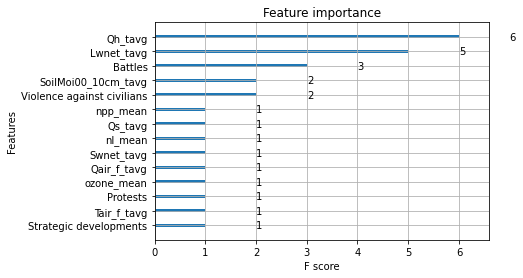

In [337]:
xgboost.plot_importance(model, max_num_features=18)

In [338]:
# Model before 2019 data
geo_social_2018 = geo_social[pd.to_datetime(geo_social.End).dt.year<2019]

In [339]:
X_2018 = geo_social_2018[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean', 'Battles','Explosions/Remote violence', 'Protests', 'Riots',
       'Strategic developments', 'Violence against civilians']]
y_2018 = geo_social_2018['CS_2']
X_train, X_test, y_train, y_test = train_test_split(X_2018, y_2018, 
                                        test_size=0.25, random_state=12345)

In [340]:
# XGBoost Tunning
model = XGBClassifier(n_estimators = 20, objective='binary:logistic', subsample = 0.5,
                      tree_method = 'exact', grow_policy = 'lossguide',
                      sampling_method = 'gradient_based', min_child_weight = 0.1,
            max_depth = 3, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
     'Overfitting: %.3f%%'% ((accuracy_score(y_test, y_pred)*100) - (accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 77.383%  Accuracy_train: 84.476%  Overfitting: -7.093%


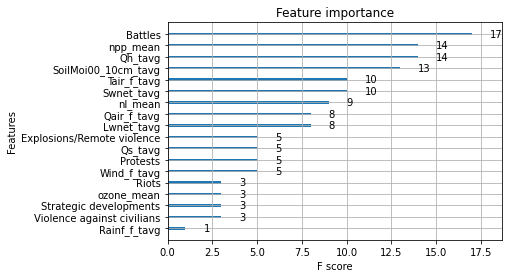

In [341]:
xgboost.plot_importance(model, max_num_features=18)